# Description

### Group information:
* **Group name: DHRL**
* Ruben Castaing: 26996541
* Harrison Allen: 97755656
* Xiaodan Liang: 73190687
* Junwei Liang: 91925811

### Goals
* Analyze the crime dataset. Find the change patterns.
* Analyze the income dataset. Find the change patterns.
* Compare previous result and see whether there is an relation between crime rate and income.

### Hypothesis
* Students drop outs rate will influence the crime rates in the future.

### Datasets

* Crime dataset
  * Dataset full name: Annual Recorded Offences for the latest Calendar Years (ANZSOC)
  * Dataset provider: stats.govt.nz
  * Dataset status: Open to public
  * Drived from: NZ Police's National Intelligence Application (NIA)
  * Area: 12 geographical districts which are policed by New Zealand
  * URL: http://nzdotstat.stats.govt.nz/wbos/index.aspx
  * Attributes: Location, Scene, Offence, Year (1994-2014)

* Income dataset
  * Dataset full name: Household income by region, household type, and source of household income
  * Dataset provider: stats.govt.nz
  * Dataset status: Open to public
  * URL: http://nzdotstat.stats.govt.nz/WBOS/Index.aspx
  * Average weekly income: Weekly household income is the sum of weekly income of all people in the household from wages and salaries, self-employment and government transfers. Average weekly household income is total weekly household income, divided by the number of households.
  * Median weekly income: The middle point of the distribution of weekly household income. For example for 99 households, the median weekly household income is the weekly income of the 50th household - when households are ranked by weekly income.
  * Number of households: Estimated number of households where at least one member is within the age range 18-64.

# Libraries

### Download libraries that we need

In [1]:
# Uncomment the packages that you want to download

# remotes::install_github("ropenscilabs/skimr")
# remotes::install_github("ropensci/visdat")
# install.packages("magrittr")
# install.packages("purrr")
# install.packages("glue")
# install.packages("shiny")
# install.packages("stringr")
# install.packages("rvest")
# remotes::install_github("dmi3kno/polite")("politer")
# install.packages("xml2")
# install.packages('rsconnect')

### Load libraries that we need

In [2]:
# %>% pipe operation
library(tidyverse)
# Read files
library(readr)
# skim()
library(skimr)
# Check missing data
library(visdat)
# Better handling of pipes
library(magrittr)
# To work with lists and map functions
library(purrr)
# To paste strings (nicer than paste())
library(glue)
# To hand strings
library(stringr)
# rvest makes scraping easier
library(rvest)
# Polite is the "polite" version of rvest
library(polite)
# Makes it easier to work with HTML and XML from R
library(xml2)
# Loading readxl to read data from excel
library(readxl)
# Load shiny library
library(shiny)
# Deploy shiny app
library(rsconnect)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




# Load datasets

#### Crime dataset

In [3]:
# Relative path to crime dataset
crime_df_location <- "Datasets/Annual_Recorded_Offendces_for_the_latest_Calender_Years_ANZSOC/TABLE.csv"
# Read dataset
crime_df <- 
  read_csv(crime_df_location, show_col_types=FALSE)
# Using spec() to retrive the full columns specification for this dataset
spec(crime_df)

cols(
  Location = col_character(),
  Scene = col_character(),
  Offence = col_character(),
  Year = col_double(),
  Measure = col_character(),
  Value = col_double(),
  Flags = col_logical()
)

#### Average_And_Median_Household_Incomes dataset

In [4]:
# Relative path to
income_df_location <- "Datasets/Datasets_Median_average_household_income_by_region.csv"
# Read dataset
income_df <-
  read_csv(income_df_location, show_col_types=FALSE)
# Using spec() to retrive the full columns specification for this dataset
spec(income_df)

cols(
  YEAR = col_double(),
  `Average Income from All Sources collected TR` = col_double(),
  `Median Income from All Sources collected TR` = col_double(),
  `Number of households (000) TR` = col_double(),
  `Average Income from All Sources collected NORTHLAND` = col_double(),
  `Median Income from All Sources collected NORTHLAND` = col_double(),
  `Number of households (000) NORTHLAND` = col_double(),
  `Average Income from All Sources collected AUCKLAND` = col_double(),
  `Median Income from All Sources collected AUCKLAND` = col_double(),
  `Number of households (000) AUCKLAND` = col_double(),
  `Average Income from All Sources collected WAIKATO` = col_double(),
  `Median Income from All Sources WAIKATO` = col_double(),
  `Number of households (000) WAIKATO` = col_double(),
  `Average Income from All Sources collected BOP` = col_double(),
  `Median Income from All Sources collected BOP` = col_double(),
  `Number of households (000) BOP` = col_double(),
  `Average Income from All So

#### Convert wide dataframe to long dataframe (income_df)

In [5]:
# Define a function and use it to process data.

reshape_df <- function(df, col_name, region_name){
    # Set up a new variable with selecting specific columns and renaming it then mutating it:
    df %<>% 
      select(YEAR, all_of(col_name)) %>%
      mutate(paste_col = all_of(col_name))
      
    #First, we convert it from wide table to long table:
    wide_df <- df %>% 
               gather(key = YEAR, value = paste_col)

    wide_df %<>% rename(Measure = YEAR, Value = paste_col) %>%
                 mutate(Region = region_name,
                        Year = rep(1998:2021))
    wide_df %<>% select(Year, Region, Measure, Value)
    
    # Thus, return our new table: 
    return(wide_df)
}

In [6]:
df1 <- income_df %>% 
       reshape_df(., 'Average Income from All Sources collected TR', 'Total Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')           
df2 <- income_df %>% 
       reshape_df(., 'Median Income from All Sources collected TR', 'Total Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df3 <- income_df %>% 
       reshape_df(., 'Number of households (000) TR', 'Total Regions') %>%
       mutate(Measure = 'Number of households')
df4 <- income_df %>% 
       reshape_df(., 'Average Income from All Sources collected NORTHLAND', 'NORTHLAND Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df5 <- income_df %>% 
       reshape_df(., 'Median Income from All Sources collected NORTHLAND', 'NORTHLAND Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df6 <- income_df %>% 
       reshape_df(., 'Number of households (000) NORTHLAND', 'NORTHLAND Regions') %>%
       mutate(Measure = 'Number of households')
df7 <- income_df %>% 
       reshape_df(., 'Average Income from All Sources collected AUCKLAND', 'AUCKLAND Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df8 <- income_df %>% 
       reshape_df(., 'Median Income from All Sources collected AUCKLAND', 'AUCKLAND Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df9 <- income_df %>% 
       reshape_df(., 'Number of households (000) AUCKLAND', 'AUCKLAND Regions') %>%
       mutate(Measure = 'Number of households')
df10 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected WAIKATO', 'WAIKATO Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df11 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources WAIKATO', 'WAIKATO Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df12 <-income_df %>% 
       reshape_df(., 'Number of households (000) WAIKATO', 'WAIKATO Regions') %>%
       mutate(Measure = 'Number of households')
df13 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected BOP', 'BOP Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df14 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected BOP', 'BOP Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df15 <-income_df %>% 
       reshape_df(., 'Number of households (000) BOP', 'BOP Regions') %>%
       mutate(Measure = 'Number of households')
df16 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected GIS/ HAWKES', 'GIS/HAWKES Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df17 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected GIS/HAWKES', 'GIS/HAWKES Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df18 <-income_df %>% 
       reshape_df(., 'Number of households (000) GIS/HAWKS', 'GIS/HAWKES Regions') %>%
       mutate(Measure = 'Number of households')
df19 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected TARANAKI', 'TARANAKI Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df20 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected TARANAKI', 'TARANAKI Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df21 <-income_df %>% 
       reshape_df(., 'Number of households (000) TARANAKI', 'TARANAKI Regions') %>%
       mutate(Measure = 'Number of households')
df22 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected MANAWATU/WHANGANUI', 'MANAWATU/WHANGANUI Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df23 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected MANAWATU/WHANGANUI', 'MANAWATU/WHANGANUI Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df24 <-income_df %>% 
       reshape_df(., 'Number of households (000) MANAWATU/WHANGANUI', 'MANAWATU/WHANGANUI Regions') %>%
       mutate(Measure = 'Number of households')
df25 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected WELLINGTON', 'WELLINGTON Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df26 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected WELLINGTON', 'WELLINGTON Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df27 <-income_df %>% 
       reshape_df(., 'Number of households (000) WELLINGTON', 'WELLINGTON Regions') %>%
       mutate(Measure = 'Number of households')
df28 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected TAS/NEL/MAL/WC', 'TAS/NEL/MAL/WC Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df29 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected TAS/NEL/MAL/WC', 'TAS/NEL/MAL/WC Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df30 <-income_df %>% 
       reshape_df(., 'Number of households (000) TAS/NEL/MAL/WC', 'TAS/NEL/MAL/WC Regions') %>%
       mutate(Measure = 'Number of households')
df31 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected CANTERBURY', 'CANTERBURY Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df32 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected CANTERBURY', 'CANTERBURY Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df33 <-income_df %>% 
       reshape_df(., 'Number of households (000) CANTERBURY', 'CANTERBURY Regions') %>%
       mutate(Measure = 'Number of households')
df34 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected OTAGO', 'OTAGO Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df35 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected OTAGO', 'OTAGO Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df36 <-income_df %>% 
       reshape_df(., 'Number of households (000) OTAGO', 'OTAGO Regions') %>%
       mutate(Measure = 'Number of households')
df37 <-income_df %>% 
       reshape_df(., 'Average Income from All Sources collected SOUTHLAND', 'SOUTHLAND Regions') %>%
       mutate(Measure = 'Average Income from All Sources collected')
df38 <-income_df %>% 
       reshape_df(., 'Median Income from All Sources collected SOUTHLAND', 'SOUTHLAND Regions') %>%
       mutate(Measure = 'Median Income from All Sources collected')
df39 <-income_df %>% 
       reshape_df(., 'Number of households (000) SOUTHLAND', 'SOUTHLAND Regions') %>%
       mutate(Measure = 'Number of households')

In [7]:
# Using rbind() to join two data frames vertically:
income_df <- rbind(df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,df19,df20,df21,df22,df23,
                   df24,df25,df26,df27,df28,df29,df30,df31,df32,df33,df34,df35,df36,df37,df38,df39)

In [8]:
# Get Average_Income_from_All_Sources_collected
average_income <- income_df[income_df$Measure == "Average Income from All Sources collected", ]
average_income %<>% mutate("Average_Income_from_All_Sources_collected" = Value)
average_income %<>% select(-c(Value, Measure))

# Get Median_Income_from_All_Sources_collected
median_income <- income_df[income_df$Measure == "Median Income from All Sources collected", ]
median_income %<>% mutate("Median_Income_from_All_Sources_collected" = Value)
median_income %<>% select(-c(Value, Measure))

# Get Number_of_households
house_hold <- income_df[income_df$Measure == "Number of households", ]
house_hold %<>% mutate("Number_of_households" = Value)
house_hold %<>% select(-c(Value, Measure))

# Join them together by using Year and Region
income_df <- left_join(average_income, median_income, by=c("Year", "Region"))
income_df <- left_join(income_df, house_hold, by=c("Year", "Region"))

In [9]:
# There is a small inconsistancy between policing districts and regions for kaikora and waikato.
# Loop throught the rows and change their names
income_df[income_df == "NORTHLAND Regions"] <- "Northlan District"
income_df[income_df == "Total Regions"] <- "Total New Zealand"
income_df[income_df == "AUCKLAND Regions"] <- "Auckland District"
income_df[income_df == "WAIKATO Regions"] <- "Waikato District"
income_df[income_df == "BOP Regions"] <- "Bay Of Plenty District"
income_df[income_df == "GIS/HAWKES Regions"] <- "Eastern District"
income_df[income_df == "TARANAKI Regions"] <- "Central District"
income_df[income_df == "MANAWATU/WHANGANUI Regions"] <- "Central District"
income_df[income_df == "WELLINGTON Regions"] <- "Wellingtion District"
income_df[income_df == "TAS/NEL/MAL/WC Regions"] <- "Tasman District"
income_df[income_df == "CANTERBURY Regions"] <- "Canterbury District"
income_df[income_df == "OTAGO Regions"] <- "Southern District"
income_df[income_df == "SOUTHLAND Regions"] <- "Southern District"
# Change column name from Region to Location so we can well match the Crime dataframe
income_df <- income_df %>% rename ('Location' = "Region")

# Routine checks

#### Crime Dataframe

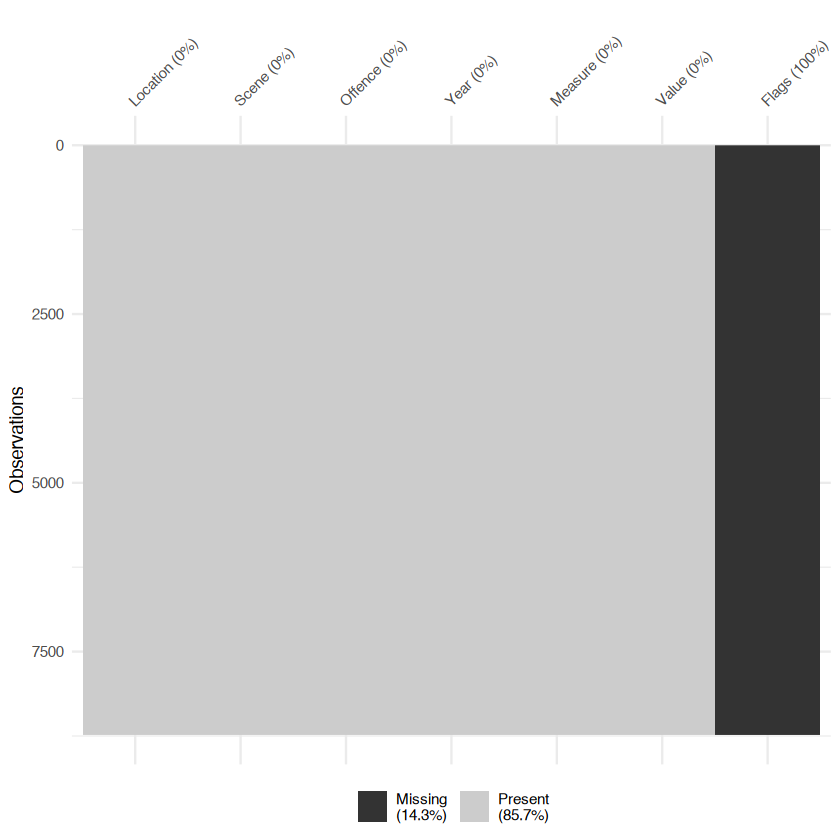

In [10]:
crime_df %>%
  # Using vis_miss() to check the missing values.
  vis_miss()

In [11]:
crime_df %>%
  # Giving us types of the columns. Columns run down the page, and data runs across.
  glimpse()

Rows: 8,734
Columns: 7
$ Location <chr> "Northland District", "Northland District", "Northland Distri…
$ Scene    <chr> "Total Scene", "Total Scene", "Total Scene", "Total Scene", "…
$ Offence  <chr> "Total Offences", "Total Offences", "Total Offences", "Total …
$ Year     <dbl> 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2…
$ Measure  <chr> "Resolved", "Resolved", "Resolved", "Resolved", "Resolved", "…
$ Value    <dbl> 6860, 7286, 7604, 7303, 7450, 8229, 8724, 8976, 8910, 8381, 7…
$ Flags    <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…


In [12]:
crime_df %>%
  # skim() function can give us a quick summary of the dataset.
  skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             8734      
Number of columns          7         
_______________________              
Column type frequency:               
  character                4         
  logical                  1         
  numeric                  2         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 Location              0             1    15    25     0       13          0
2 Scene                 0             1    11    11     0        1          0
3 Offence               0             1    14    82     0       16          0
4 Measure               0             1     8     8     0        2          0

── Variable type: logical ──────────────────────────────────────────

In [13]:
crime_df %>%
  # Get the first ten observations.
  head(10)

Location,Scene,Offence,Year,Measure,Value,Flags
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<lgl>
Northland District,Total Scene,Total Offences,1994,Resolved,6860,NA
Northland District,Total Scene,Total Offences,1995,Resolved,7286,NA
Northland District,Total Scene,Total Offences,1996,Resolved,7604,NA
Northland District,Total Scene,Total Offences,1997,Resolved,7303,NA
Northland District,Total Scene,Total Offences,1998,Resolved,7450,NA
Northland District,Total Scene,Total Offences,1999,Resolved,8229,NA
Northland District,Total Scene,Total Offences,2000,Resolved,8724,NA
Northland District,Total Scene,Total Offences,2001,Resolved,8976,NA
Northland District,Total Scene,Total Offences,2002,Resolved,8910,NA


In [14]:
crime_df %>%
  # Get the first ten ranfom observations.
  sample_n(10)

Location,Scene,Offence,Year,Measure,Value,Flags
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<lgl>
Bay Of Plenty District,Total Scene,"Robbery, extortion and related offences",2002,Resolved,60,NA
Waitemata District,Total Scene,Total Offences,1999,Resolved,14131,NA
Auckland District,Total Scene,Total Offences,2011,Recorded,55220,NA
Central District,Total Scene,Miscellaneous offences,1997,Recorded,169,NA
Total New Zealand,Total Scene,"Abduction, harassment and other related offences against a person",2013,Recorded,13763,NA
Total New Zealand,Total Scene,"Abduction, harassment and other related offences against a person",2008,Recorded,12719,NA
Canterbury District,Total Scene,"Fraud, deception and related offences",2009,Resolved,898,NA
Counties/Manukau District,Total Scene,Sexual assault and related offences,2014,Resolved,213,NA
Canterbury District,Total Scene,"Offences against justice procedures, government security and government operations",2001,Resolved,1301,NA


In [15]:
# Get unique value

# Location
unique_location_value <- crime_df %>%
  # Select column
  select("Location") %>%
  # Get distinct value
  unique()
# Offence
unique_offence_value <- crime_df %>%
  # Select column
  select("Offence") %>%
  # Get distinct value
  unique()
# Measure
unique_measure_value <- crime_df %>%
  # Select column
  select("Measure") %>%
  # Get distinct value
  unique()
# Scene
unique_scene_value <- crime_df %>%
  # Select column
  select("Scene") %>%
  # Get distinct value
  unique()

#### Income Dataframe

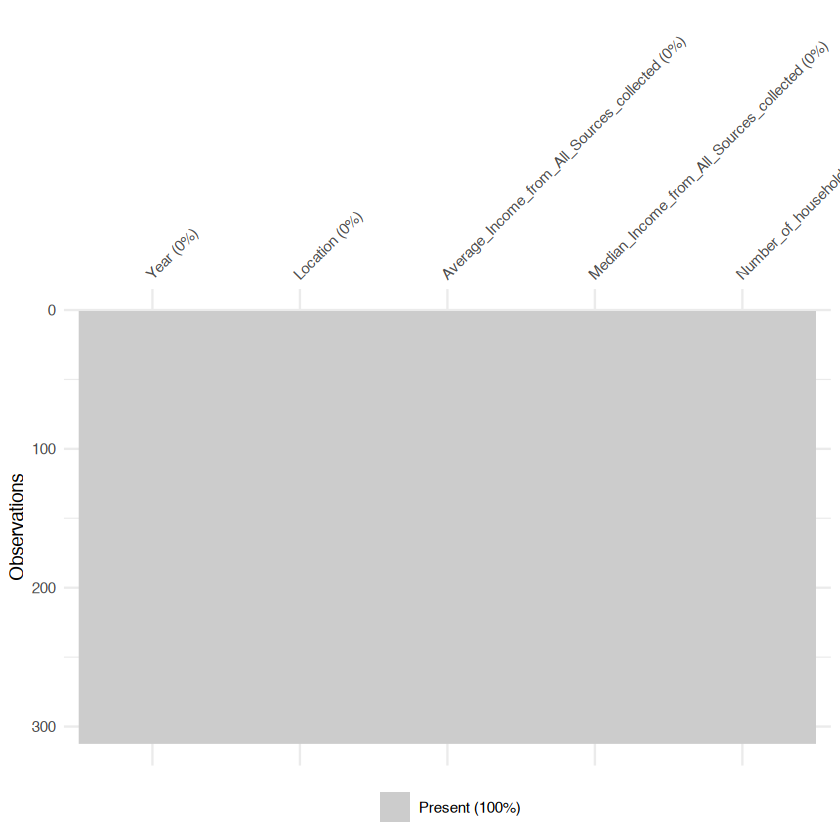

In [16]:
income_df %>%
  # Using vis_miss() to check the missing values.
  vis_miss()

In [17]:
income_df %>%
  # Giving us types of the columns. Columns run down the page, and data runs across.
  glimpse()

Rows: 312
Columns: 5
$ Year                                      <int> 1998, 1999, 2000, 2001, 2002…
$ Location                                  <chr> "Total New Zealand", "Total …
$ Average_Income_from_All_Sources_collected <dbl> 910, 943, 950, 1012, 1063, 1…
$ Median_Income_from_All_Sources_collected  <dbl> 756, 786, 794, 845, 891, 912…
$ Number_of_households                      <dbl> 1227.2, 1240.1, 1251.1, 1260…


In [18]:
income_df %>%
  # skim() function can give us a quick summary of the dataset.
  skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             312       
Number of columns          5         
_______________________              
Column type frequency:               
  character                1         
  numeric                  4         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 Location              0             1    15    22     0       11          0

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable                             n_missing complete_rate  mean     sd
1 Year                                              0             1 2010.   6.93
2 Average_Income_from_All_Sources_collected         0             1 1361. 382.  
3 Median_Income_

In [19]:
income_df %>%
  # Get the first ten observations.
  head(10)

Year,Location,Average_Income_from_All_Sources_collected,Median_Income_from_All_Sources_collected,Number_of_households
<int>,<chr>,<dbl>,<dbl>,<dbl>
1998,Total New Zealand,910,756,1227.2
1999,Total New Zealand,943,786,1240.1
2000,Total New Zealand,950,794,1251.1
2001,Total New Zealand,1012,845,1260.7
2002,Total New Zealand,1063,891,1276.9
2003,Total New Zealand,1110,912,1312.5
2004,Total New Zealand,1157,959,1341.0
2005,Total New Zealand,1208,1017,1357.9
2006,Total New Zealand,1248,1080,1381.3


In [20]:
income_df %>%
  # Get the first ten ranfom observations.
  sample_n(10)

Year,Location,Average_Income_from_All_Sources_collected,Median_Income_from_All_Sources_collected,Number_of_households
<int>,<chr>,<dbl>,<dbl>,<dbl>
2014,Central District,1632,1419,36.8
2000,Total New Zealand,950,794,1251.1
2010,Auckland District,1519,1244,464.7
2017,Tasman District,1651,1421,58.1
2018,Northlan District,1649,1343,59.6
2012,Waikato District,1499,1219,133.2
2004,Canterbury District,1112,959,176.3
2003,Auckland District,1264,1030,412.8
2013,Total New Zealand,1534,1318,1442.0


In [21]:
# Get unique value

# Year
unique_year_value <- income_df %>%
  # Select column
  select("Year") %>%
  # Get distinct value
  unique()
# Location
unique_location_value <- income_df %>%
  # Select column
  select("Location") %>%
  # Get distinct value
  unique()
# Average_Income_from_All_Sources_collected
average_income_value <- income_df %>%
  # Select column
  select("Average_Income_from_All_Sources_collected") %>%
  # Get distinct value
  unique()
# Median_Income_from_All_Sources_collected
median_income_value <- income_df %>%
  # Select column
  select("Median_Income_from_All_Sources_collected") %>%
  # Get distinct value
  unique()
# Median_Income_from_All_Sources_collected
house_hold_value <- income_df %>%
  # Select column
  select("Number_of_households") %>%
  # Get distinct value
  unique()

# Crime dataset summarise

* Number of rows: 8734
* Number of columns: 7
* Missing data: Flag
* Attributes
  * Location(chr):
    * Auckland District
    * Bay Of Plenty District
    * Canterbury District
    * Central District
    * Counties/Manukau District
    * Eastern District
    * Northlan District
    * Southern District
    * Tasman District
    * Total New Zealand
    * Waikato District
    * Waitemata District
    * Wellington District
  * Scene(chr):
    * Total Scene
  * Offence(chr):
    * Abduction, harassment and other related offences against a person
    * Acts intended to cause injury
    * Dangerous or negligent acts endangering persons
    * Fraud, deception and related offences
    * Homicide and related offences
    * Illicit drug offences
    * Miscellaneous offences
    * Offences against justice procedures, government security and government operations
    * Prohibited and regulated weapons and explosives offences
    * Property damage and enviromental pollution
    * Public order offences
    * Robbery, extortion and related offences
    * Sexual assault and related offences
    * Theft and related offences
    * Total Offences
    * Unlawful entry with intent/burglary, break and enter
  * Year(dbl):
    * 1994-2014
  * Measure(chr):
    * Resolved
    * Recorded
  * Value(dbl):
    * 0-477596
  * Flag(lgl):
    * NA

# Income dataset summarise

* Number of rows: 312
* Number of columns: 4
* Attributes
  * Year(dbl):
    * 1998-2021
  * Location(chr):
    * Auckland District
    * Bay Of Plenty District
    * Canterbury District
    * Central District
    * Eastern District
    * Northlan District
    * Southern District
    * Tasman District
    * Total New Zealand
    * Waikato District
    * Wellingtion District
  * Number_of_households(dbl):
    * 701-2555
  * Average_Income_from_All_Sources_collected(dbl):
    * 30.3-1620.6
  * Median_Income_from_All_Sources(dbl):
    * 575-2279

# Ploting

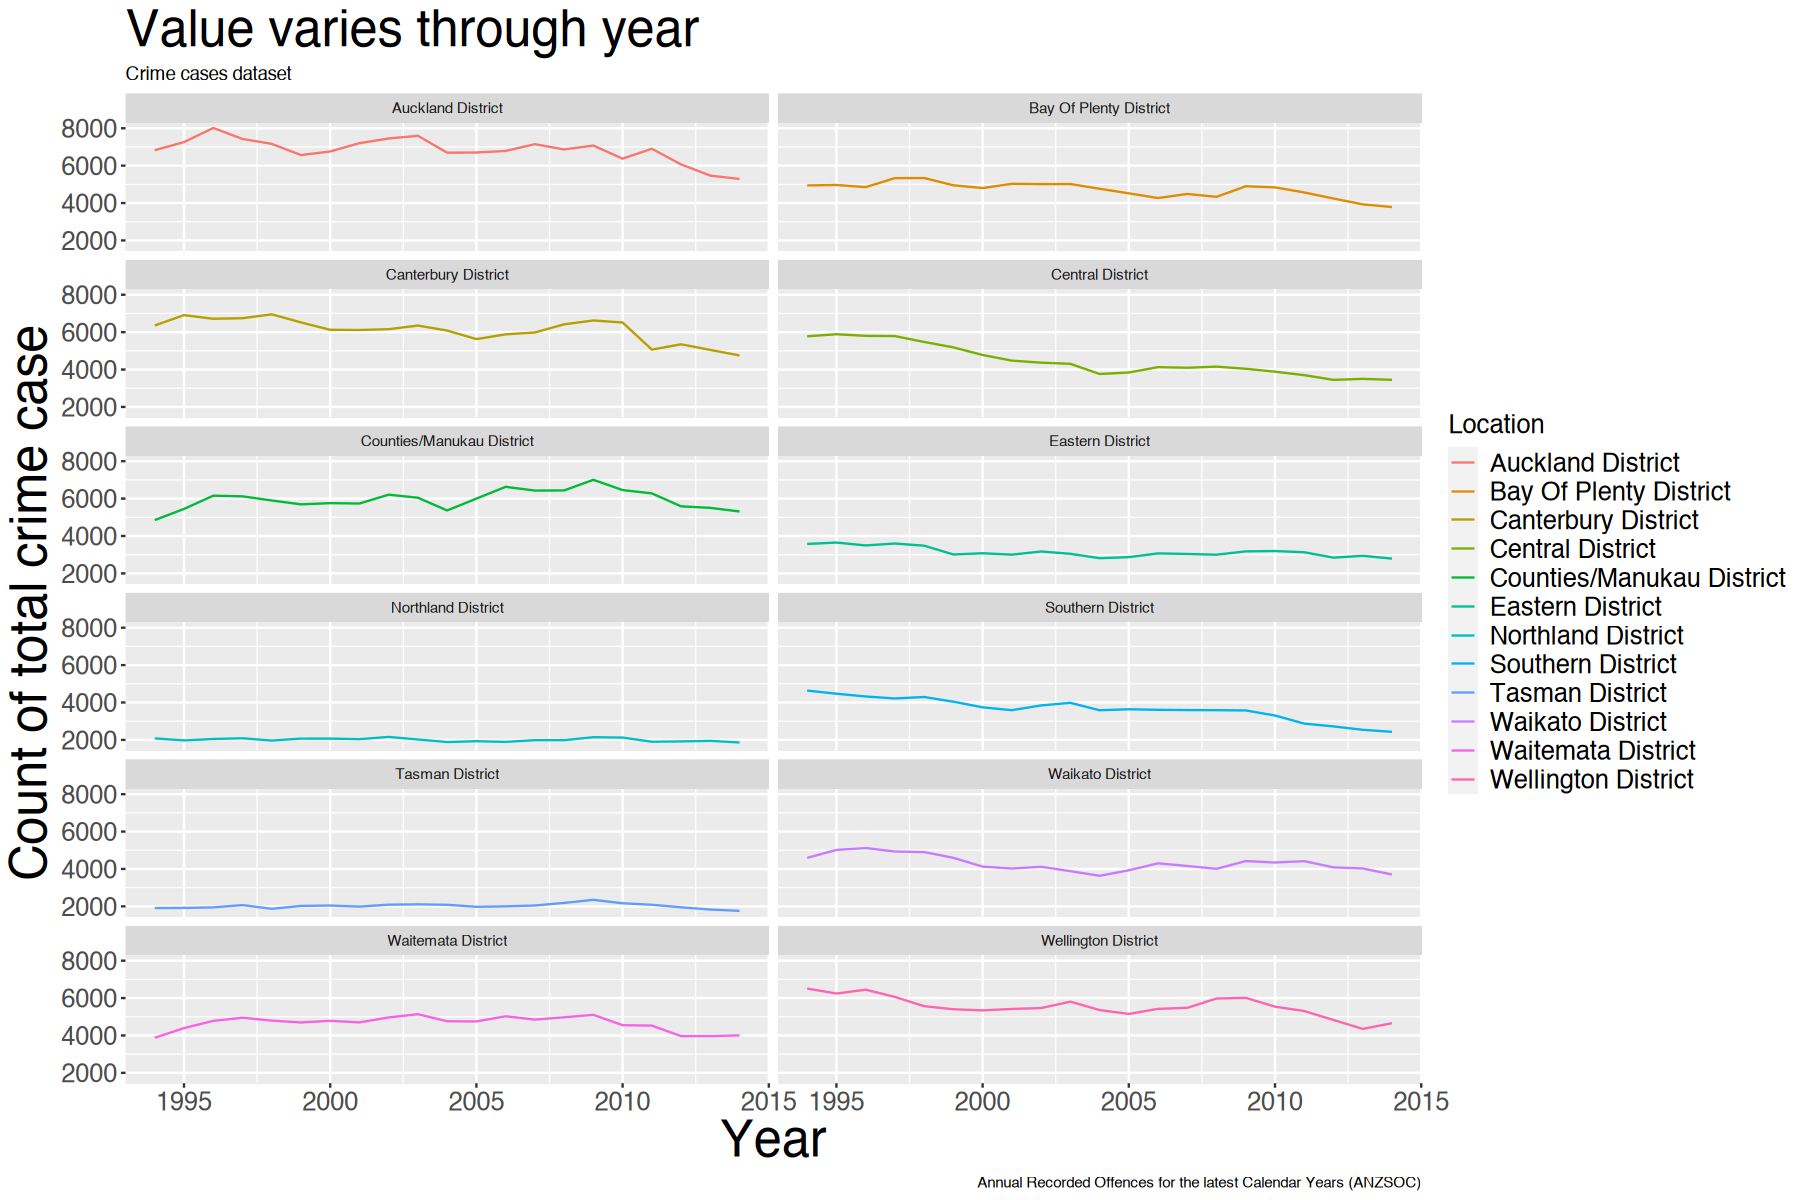

In [22]:
# Line graph

# Process dataframe
tmp_crime_df <- crime_df[crime_df$Location!="Total New Zealand",] %>%
  .[.$Measure=="Recorded",] %>%
  group_by(Location, Year) %>% # Group by location
  summarise(.groups = 'keep', Mean_value = mean(Value)) # Calculate the value

# Mapping
tmp_mapped <- tmp_crime_df %>%
  ggplot(mapping = 
        aes(x = Year, # X axis
            y = Mean_value, # Y axis
            colour = Location)) # Assign colour for each different locations
# Labels
tmp_labeled <- tmp_mapped + 
  ggtitle("Value varies through year") + # Set title
  xlab("Year") + # Change x axis lable
  ylab("Count of total crime case") + # Change y axis lable
  labs(subtitle = "Crime cases dataset", # Add subtitle
       caption = "Annual Recorded Offences for the latest Calendar Years (ANZSOC)") # Add caption

# Plotting
crime_df_plot <- tmp_labeled +
  theme(plot.title = element_text(size = 30),
        axis.title = element_text(size = 30),
        axis.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        legend.text = element_text(size = 15)) + # Change size
  facet_wrap(~Location, nrow = 6) +
  geom_line() # Plot

# Resizing plots in R kernel for jupyter notebook
options(repr.plot.width=15, repr.plot.height=10)

# Display plot
crime_df_plot

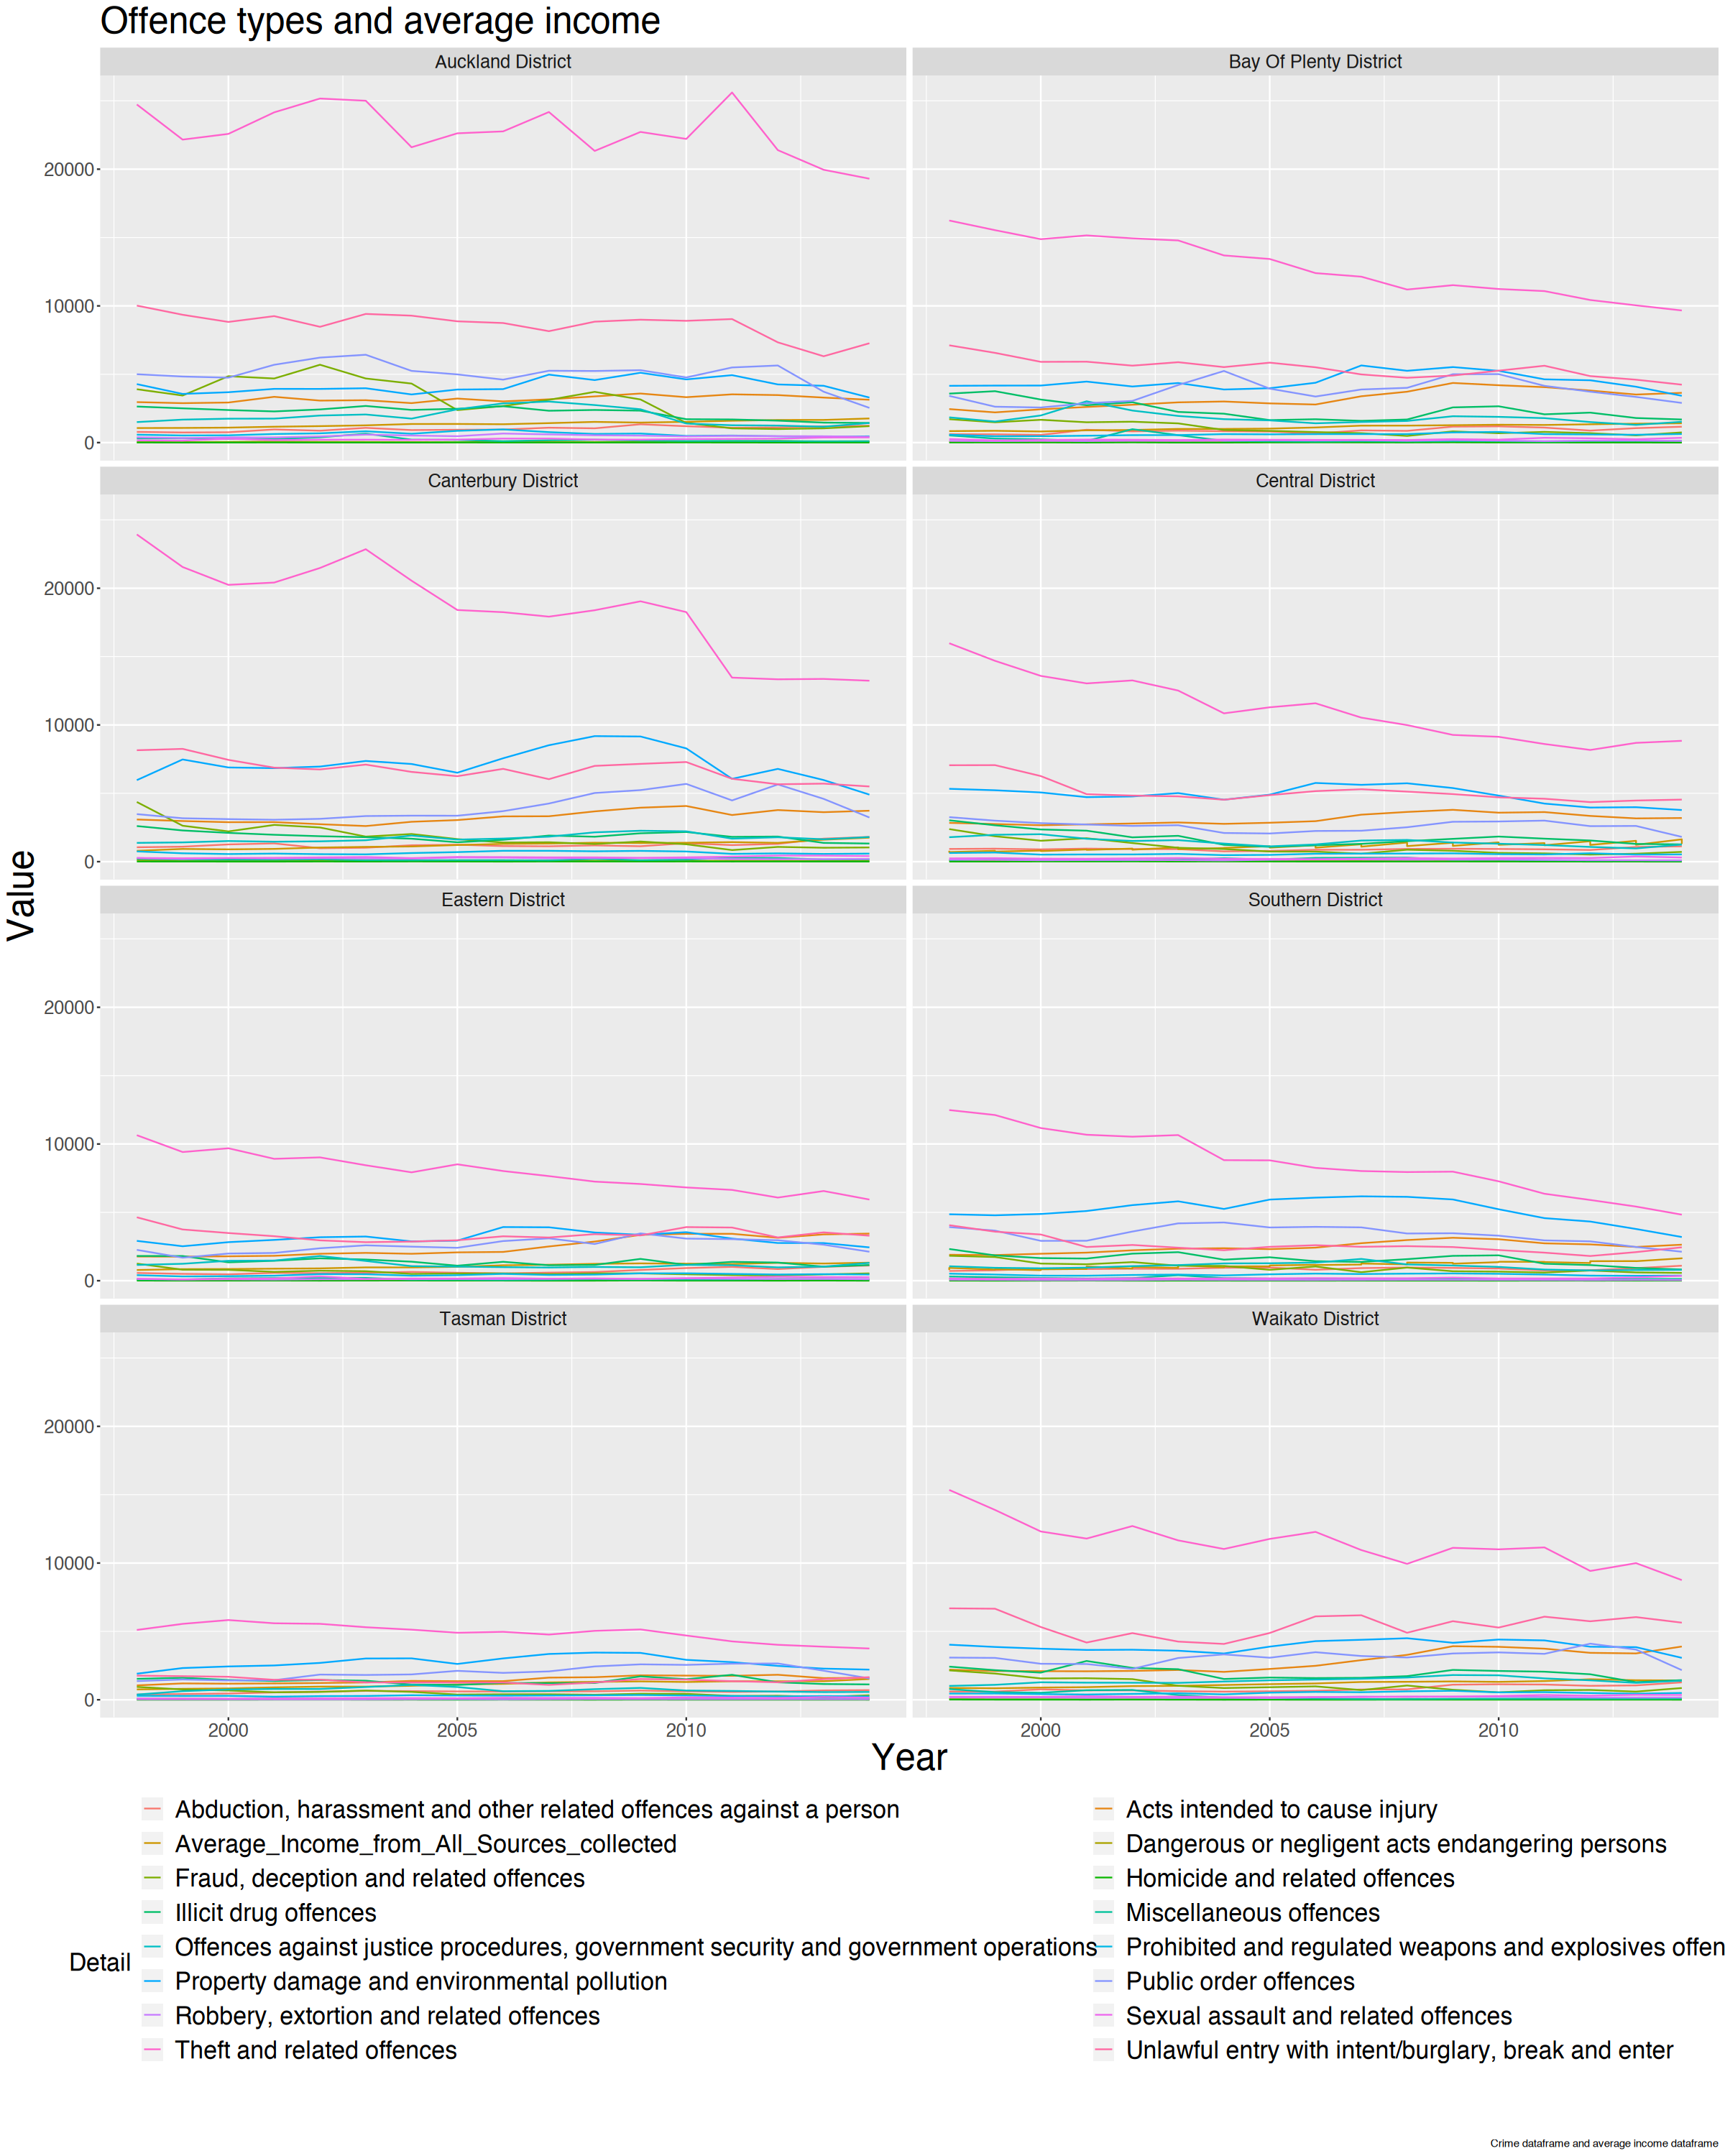

In [23]:
# Line graph

# Process dataframe
# Since income dataframe's locations are the subset of the crime dataframe's locations.
# We considered modifing the income dataframe and merge two dataframes vertically
inner_joined_df <- inner_join(income_df, crime_df, by=c("Year","Location")) # Use inner join to join two tables. Since we only want matched value
inner_joined_df <- inner_joined_df[inner_joined_df$Measure == "Recorded", ] # In this case we only want the "Recorded" one

tmp_income_df <- inner_joined_df %>% 
  select(c("Year", "Location", "Average_Income_from_All_Sources_collected")) # Select Year, Location, Average_Income_from_All_Sources_collected
tmp_income_df %<>% rowwise() %>% # One row at a time
  mutate(Detail = "Average_Income_from_All_Sources_collected") # And lables for each individual Location. And dataframe length won't change.
tmp_income_df %<>% rename('Value' = "Average_Income_from_All_Sources_collected") # Rename Average_Income_from_All_Sources_collected to Value
tmp_income_df %<>% select(Year, Location, Detail, Value) # Select Year, Location, Detail, Value

tmp_crime_df <- inner_joined_df %>%
  select(-Flags) # Remove Flag column
# Recall that Average_Income_from_All_Sources_collected has already been divided by the number of households (From StatsNz)
tmp_crime_df %<>% select(c(Year, Location, Offence, Value)) # Select Year, Average_Income, Offence and Value
tmp_crime_df %<>% rename('Detail' = "Offence") # Rename Offence to Detail

final_df <- rbind(tmp_crime_df, tmp_income_df) # Use rbind to merge two dataframes vertically
final_df <- final_df[final_df$Location!="Total New Zealand",] # Remove Value, so we can show the plot better.
final_df <- final_df[final_df$Detail!="Total Offences",] # Remove Value in order to present the plot better



# Mapping
tmp_mapped <- final_df %>%
  ggplot(mapping = 
        aes(x = Year, # X axis
            y = Value, # Y axis
            colour = Detail)) # Assign colour for each different Details

# Labels
tmp_labeled <- tmp_mapped + 
  ggtitle("Offence types and average income") + # Set title
  xlab("Year") + # Change x axis lable
  ylab("Value") + # Change y axis lable
  labs(caption = "Crime dataframe and average income dataframe") # Add caption

# Plotting
crime_income_plot <- tmp_labeled +
  theme(plot.title = element_text(size = 30),
        axis.title = element_text(size = 30),
        axis.text = element_text(size = 15),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.position = "bottom") + # Change size and legend position
  guides(color=guide_legend(nrow=10,byrow=TRUE)) +
  facet_wrap(~Location, nrow = 6) + # Facet_wrap base on different locations
  theme(strip.text.x = element_text(size = 15)) + # Change facet font size
  geom_line() # Plot

# Resizing plots in R kernel for jupyter notebook
options(repr.plot.width=20, repr.plot.height=25)

# Display plot
crime_income_plot

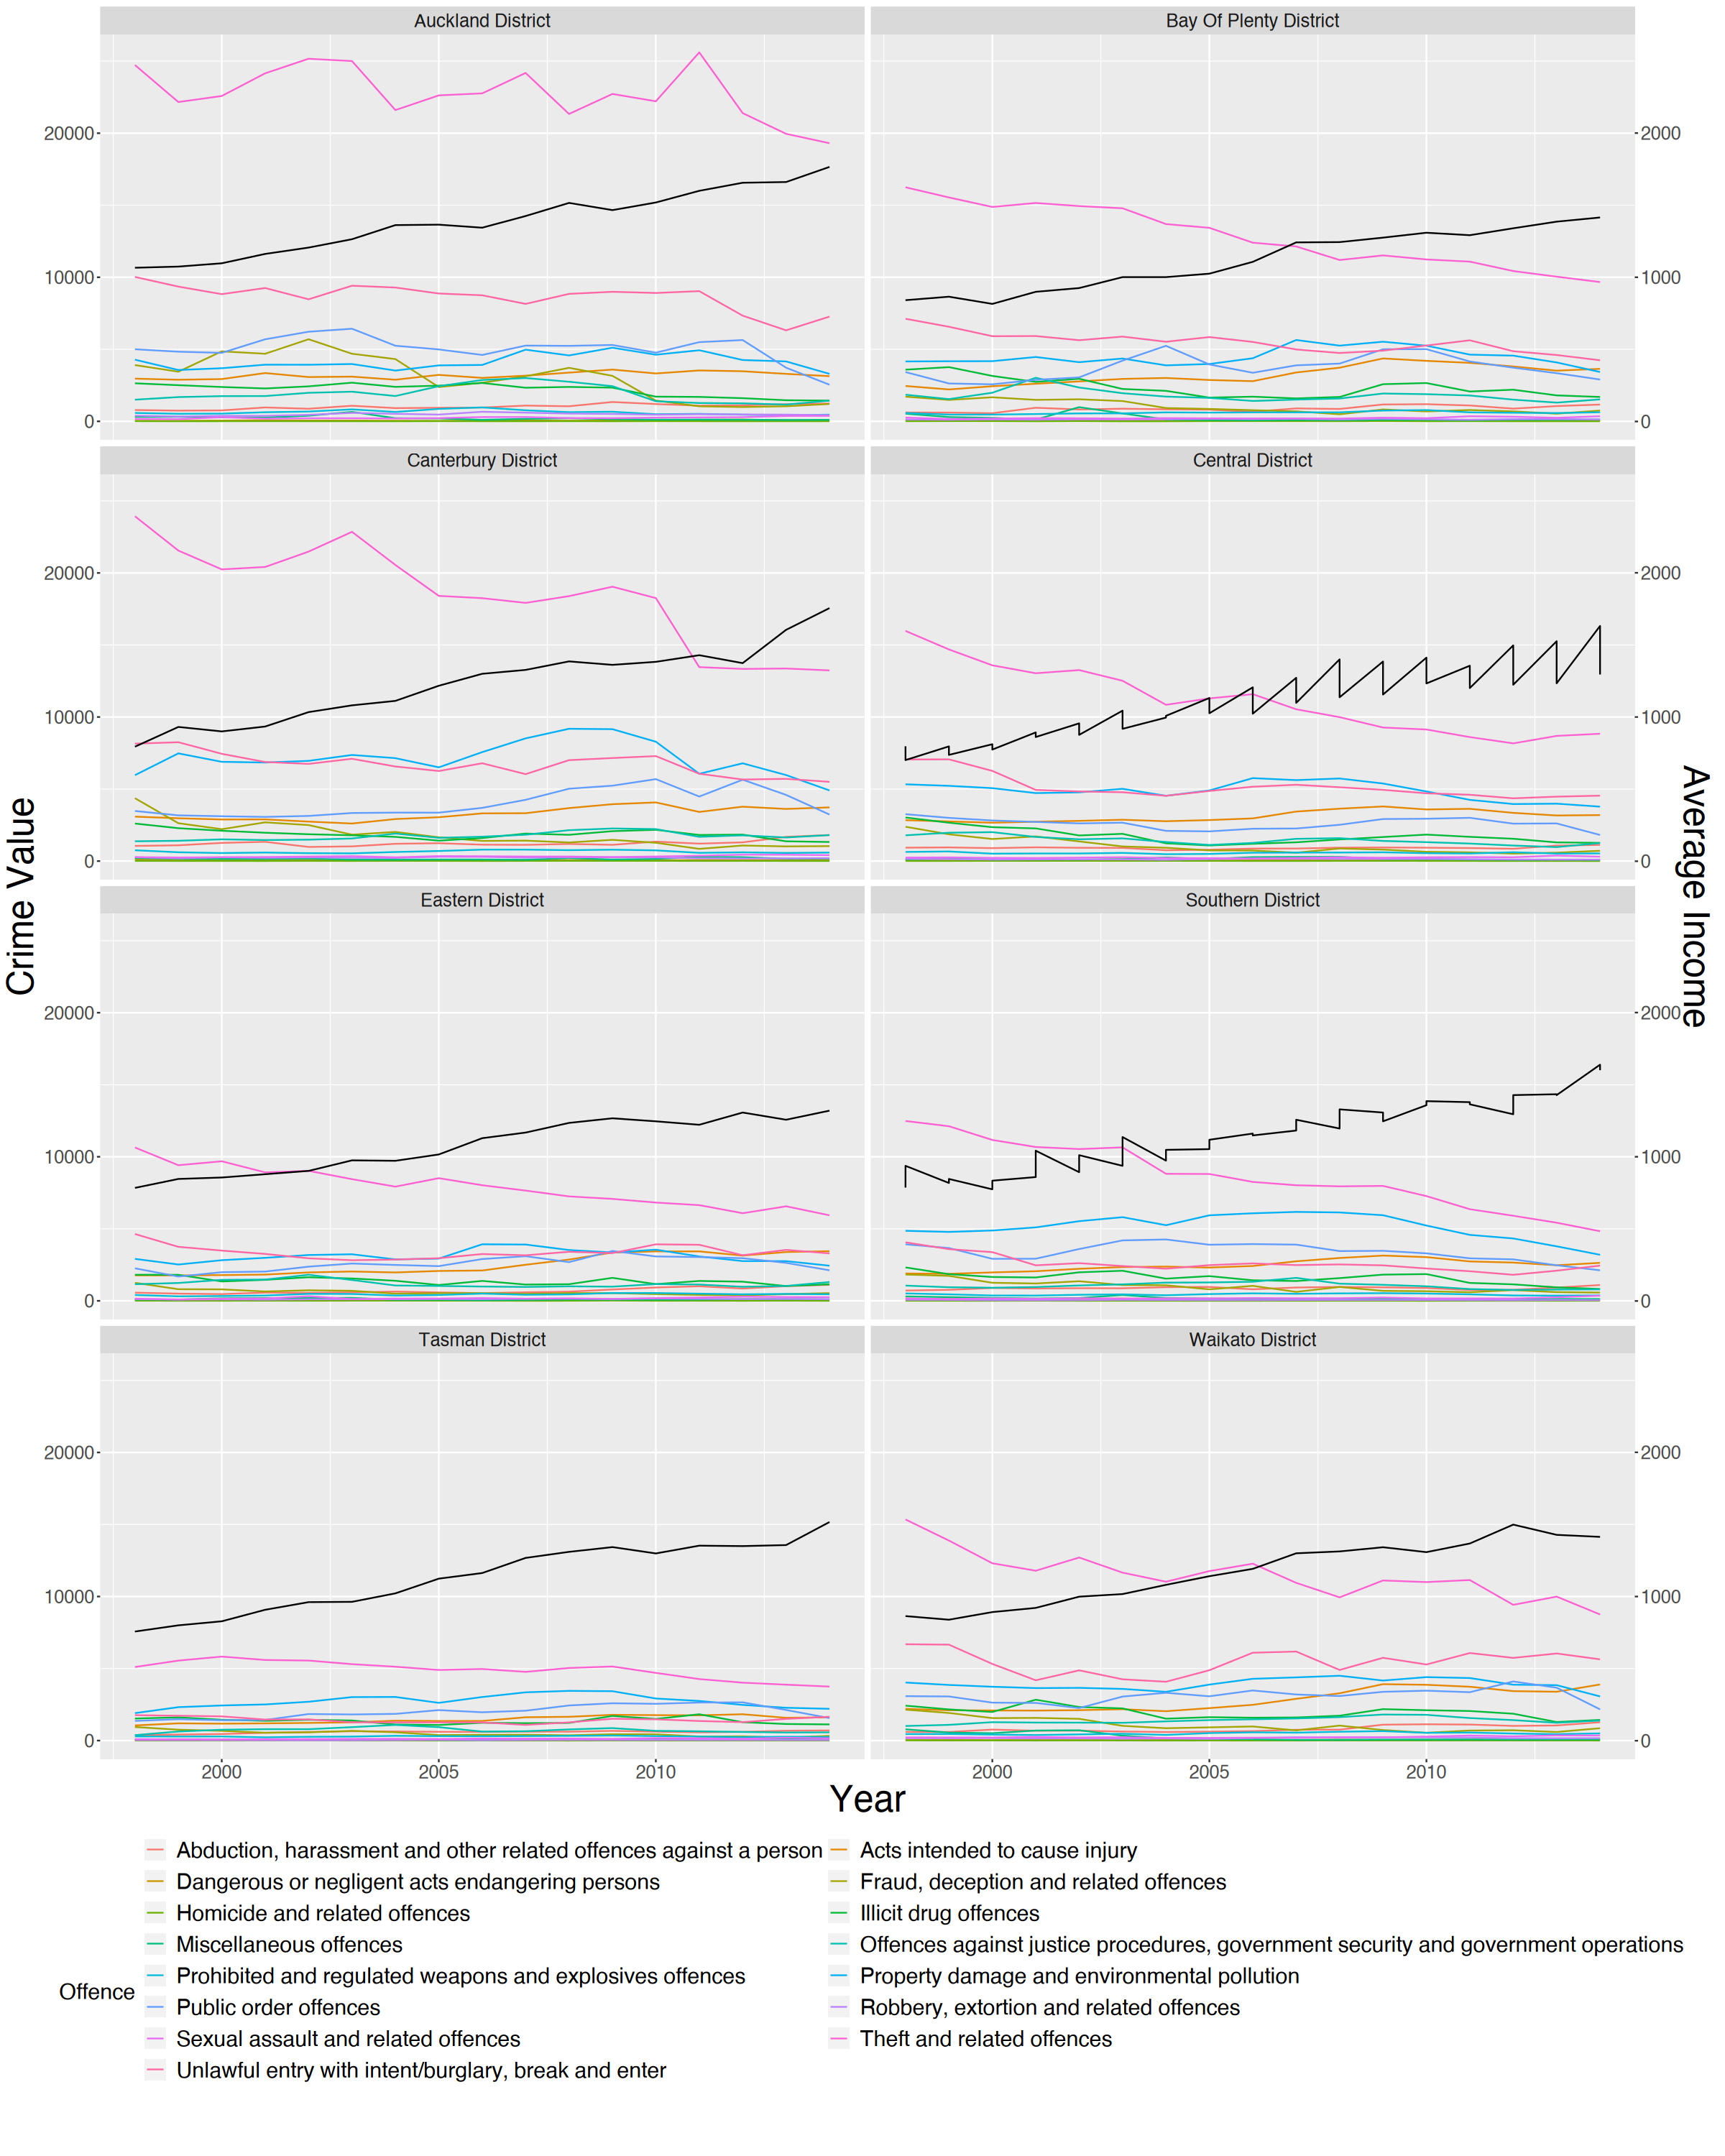

In [24]:
# Double Y axis

# Process dataframe
remove_total_inner_joined_df <- inner_joined_df[inner_joined_df$Location!="Total New Zealand",] # Remove Value, so we can show the plot better.
remove_total_inner_joined_df <- remove_total_inner_joined_df[remove_total_inner_joined_df$Offence!="Total Offences",] # Remove Value in order to present the plot better

# Mapping
tmp_mapped <- remove_total_inner_joined_df %>% 
  ggplot(., aes(x = Year)) + # Set x axis
  geom_line(aes(y = Value, color = Offence)) + # First line
  geom_line(aes(y = Average_Income_from_All_Sources_collected*10)) # Second line. And we mutiple the income by 10 so we can see the changes.
  
# Lables
tmp_labeled <-  tmp_mapped +
  scale_y_continuous(
    name = "Crime Value", # Features of the first axis
    sec.axis = sec_axis(~./10, name="Average Income") # Add a second axis and specify its features. And we divide the value by 10
  )

# Plotting
double_axis_plot <- tmp_labeled + 
  facet_wrap(~Location, nrow = 6) +
  theme(plot.title = element_text(size = 30),
        axis.title = element_text(size = 30),
        axis.text = element_text(size = 15),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        legend.position = "bottom") + # Change size and legend position
  guides(color=guide_legend(nrow=10,byrow=TRUE)) + # Assigne the layout
  theme(strip.text.x = element_text(size = 15)) # Facet title font size

# Output
double_axis_plot


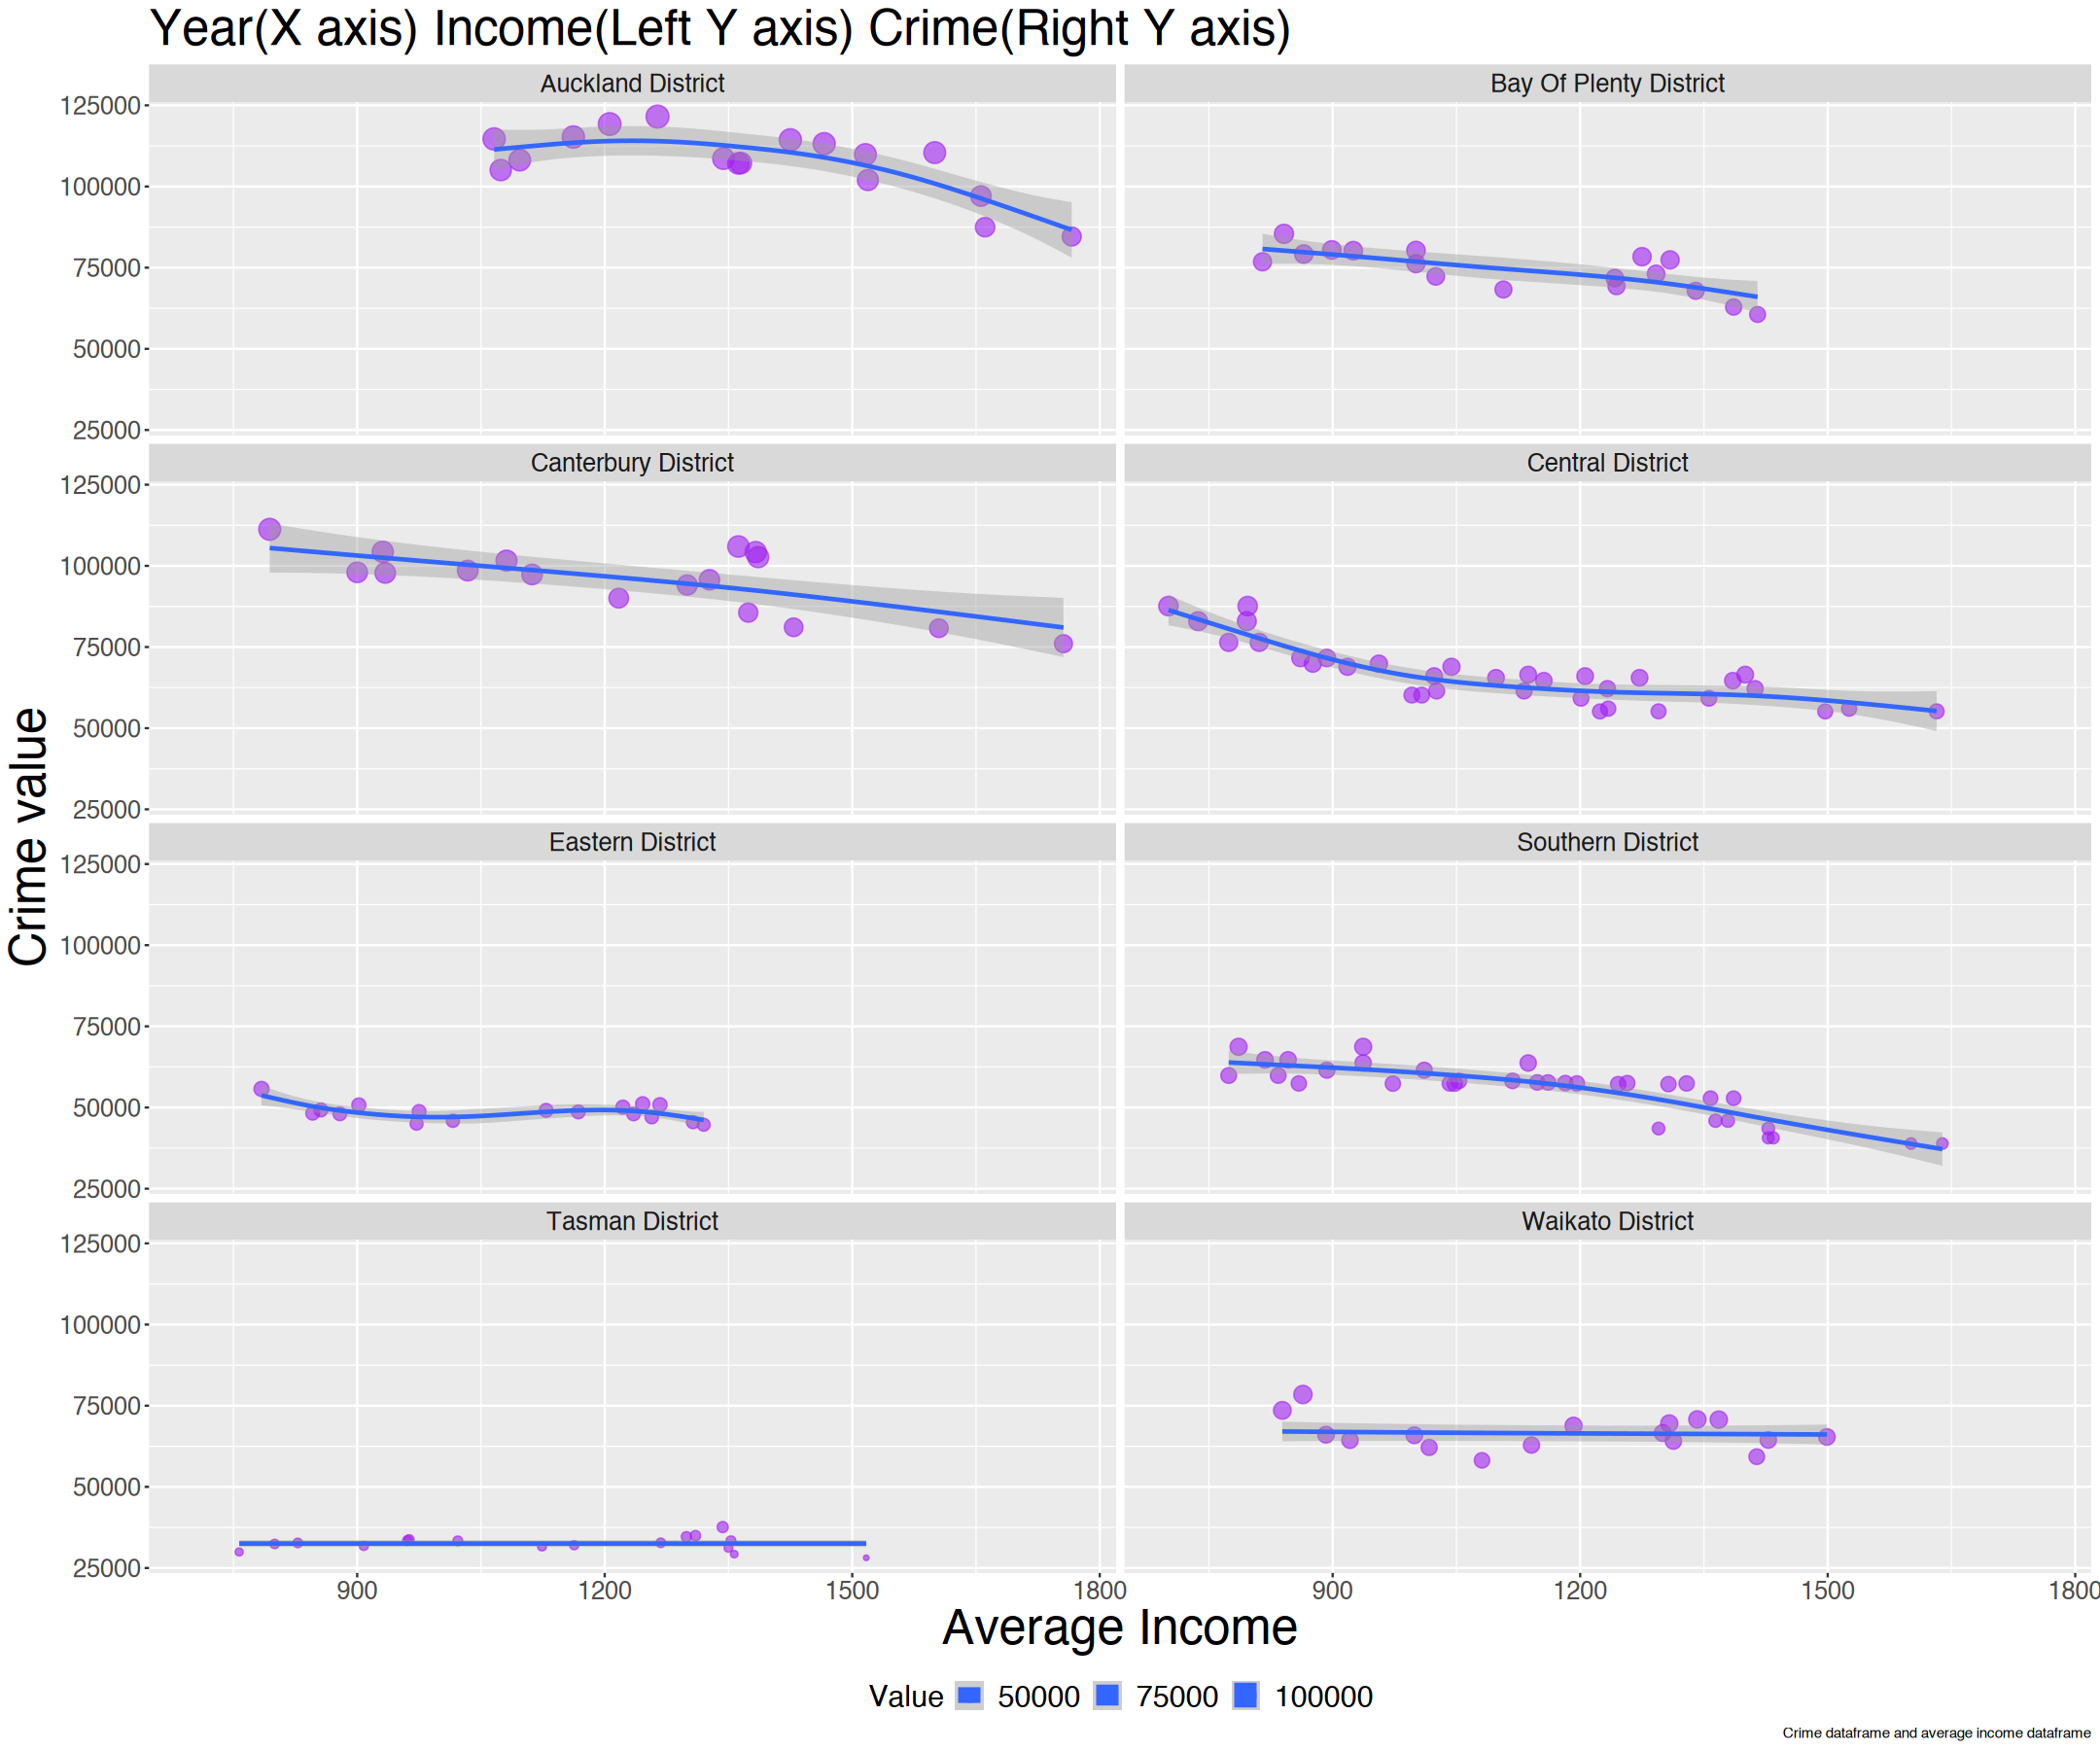

In [25]:
 # Dot and Line

# Process dataframe
tmp_inner_joined_df <- inner_joined_df[inner_joined_df$Measure == "Recorded", ] %>% # Filter out the Recorded
  select("Year", "Location", "Average_Income_from_All_Sources_collected", "Offence", "Value") %>% # Select value
  group_by(Year, Location, Average_Income_from_All_Sources_collected) %>% # Group by Year, Location and Offence
  summarise(Value = sum(Value), .groups="keep") # Calculate mean value
tmp_inner_joined_df <- tmp_inner_joined_df[tmp_inner_joined_df$Location != "Total New Zealand", ]

# Mapping
tmp_mapped <- tmp_inner_joined_df %>% 
  ggplot(mapping = 
         aes(x = Average_Income_from_All_Sources_collected, # X: Average Income
             y = Value, # Y: Offence value
             size = Value))
  
# Lables
tmp_labeled <- tmp_mapped +
  ggtitle("Income(X axis) Crime(Y axis)") + # Give plot a main title
  xlab("Average Income") + # Change x axis label
  ylab("Crime value") + # Change y axis label
  labs(caption = "Crime dataframe and average income dataframe") # Add caption to the bottom right

# Plotting
income_crime_XY <- tmp_labeled +
  geom_point(alpha = .6, color="purple") + # Plot it and give it 60% transparent
  geom_smooth(se = TRUE, # Add confidence interval around smooth
              method = "gam", # Apply smooth method(function)
              formula = y ~ s(x, bs = "cs")) + # Apply formula. Since observations are larger than 1000, we use y ~ s(x, bs = "cs")
  facet_wrap(~Location, nrow = 6) + 
  theme(plot.title = element_text(size = 30),
        axis.title = element_text(size = 30),
        axis.text = element_text(size = 15),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        legend.position = "bottom") + # Change size and legend position
  guides(color=guide_legend(nrow=10,byrow=TRUE)) + # Assigne the layout
  theme(strip.text.x = element_text(size = 30)) # Facet title font size

#Output
income_crime_XY

# Shiny

In [25]:
# function used to summarise dataframes
summary_dataframe <- function(dataFrame, location, detail){
    # Process dataFrame
    tmp_df <- dataFrame[dataFrame$Detail==detail,]
    tmp_df <- tmp_df[tmp_df$Location==location,]
    # Summary display
    summary <- summary(tmp_df)
    return(summary)
}

In [26]:
# Function used to generate a plot
generate_plot_by_detail <- function(dataFrame, location, detail) {
    # Process dataFrame
    tmp_df <- dataFrame[dataFrame$Detail==detail,]
    tmp_df <- tmp_df[tmp_df$Location==location,]
    # Mapping
    tmp_mapped <- tmp_df %>%
      ggplot(mapping = 
            aes(x = Year, # X axis
                y = Value)) # Y axis
    # Labels
    tmp_labeled <- tmp_mapped + 
      ggtitle(glue("{detail} ({location})")) + # Set title
      xlab("Year") + # Change x axis lable
      ylab("Value") + # Change y axis lable
      labs(caption = "Crime dataframe and average income dataframe") # Add caption
    # Plotting
    f_plot <- tmp_labeled +
      geom_line(color = "purple") # Plot
    return(f_plot)
}


In [27]:
# Function used to generate a plot
generate_income_plot_by_location <- function(dataFrame, location) {
    # Process dataFrame
    tmp_df <- dataFrame[dataFrame$Location==location,]
    # Mapping
    tmp_mapped <- tmp_df %>%
      ggplot(mapping = 
            aes(x = Year, # X axis
                y = Average_Income_from_All_Sources_collected)) # Y axis
    # Labels
    tmp_labeled <- tmp_mapped + 
      ggtitle(glue("Average Income ({location})")) + # Set title
      xlab("Year") + # Change x axis lable
      ylab("Average Income") + # Change y axis lable
      labs(caption = "Average income dataframe") # Add caption
    # Plotting
    f_plot <- tmp_labeled +
      geom_line(color = "blue") # Plot
    return(f_plot)
}

In [28]:
locations = c("Auckland District", "Waikato District", "Bay Of Plenty District", "Eastern District", "Central District", "Tasman District",
              "Canterbury District", "Southern District")

detail_types = c("Homicide and related offences", "Acts intended to cause injury", "Sexual assault and related offences", 
               "Dangerous or negligent acts endangering persons", "Abduction, harassment and other related offences against a person", 
               "Robbery, extortion and related offences", "Unlawful entry with intent/burglary, break and enter", "Theft and related offences",
               "Fraud, deception and related offences", "Illicit drug offences", "Prohibited and regulated weapons and explosives offences",
               "Property damage and environmental pollution", "Public order offences", "Offences against justice procedures, government security and government operations",
               "Miscellaneous offences")

# Use a fluid Bootstrap layout
ui = fluidPage(
    # Give the page a title
    titlePanel("Crime And Income"),
    # Generate a row with a sidebar
    sidebarLayout(
        # Define the sidebar with one input
        sidebarPanel(
          # Get Location
          selectInput("location", "Locations:", 
                      choices=locations),
          # Get Detail
          selectInput("detailType", "Detail:", 
                      choices = detail_types,
                      multiple = FALSE),
          # Show summary
          checkboxInput("summary", "Show summary", TRUE)
        ),
        # Create a spot for the barplot
        mainPanel(
          plotOutput("locationIncomePlot"),
          plotOutput("detailPlot"),

          verbatimTextOutput("summary")
        )
    )
)

# Define a server for the Shiny app
server = function(input, output) {
    # Fill in the spot we created for a plot
    # Location income plot
    output$locationIncomePlot <- renderPlot({
      # Render a lineplot
      generate_income_plot_by_location(income_df, input$location) # Generate the income plot for different locations
    })
    
    # Average income and crime plot
    output$detailPlot <- renderPlot({
      # Render a lineplot
      generate_plot_by_detail(final_df, input$location, input$detailType) # Generate income and crime plot for different locations
    })
    
    # Data summary information
    output$summary <- renderPrint({
      if (!input$summary) return(cat("The data summary information is hidden."))
      summary_dataframe(final_df, input$location, input$detailType)
    })  
}

shinyApp(ui = ui, server = server)



Listening on http://127.0.0.1:7927



# Saving plots

In [43]:
# Check Working directory
getwd()

[1] "/Users/junweil/Desktop/201-Group-Project/201-group-project"

In [44]:
# Set path
setwd('~/Desktop')

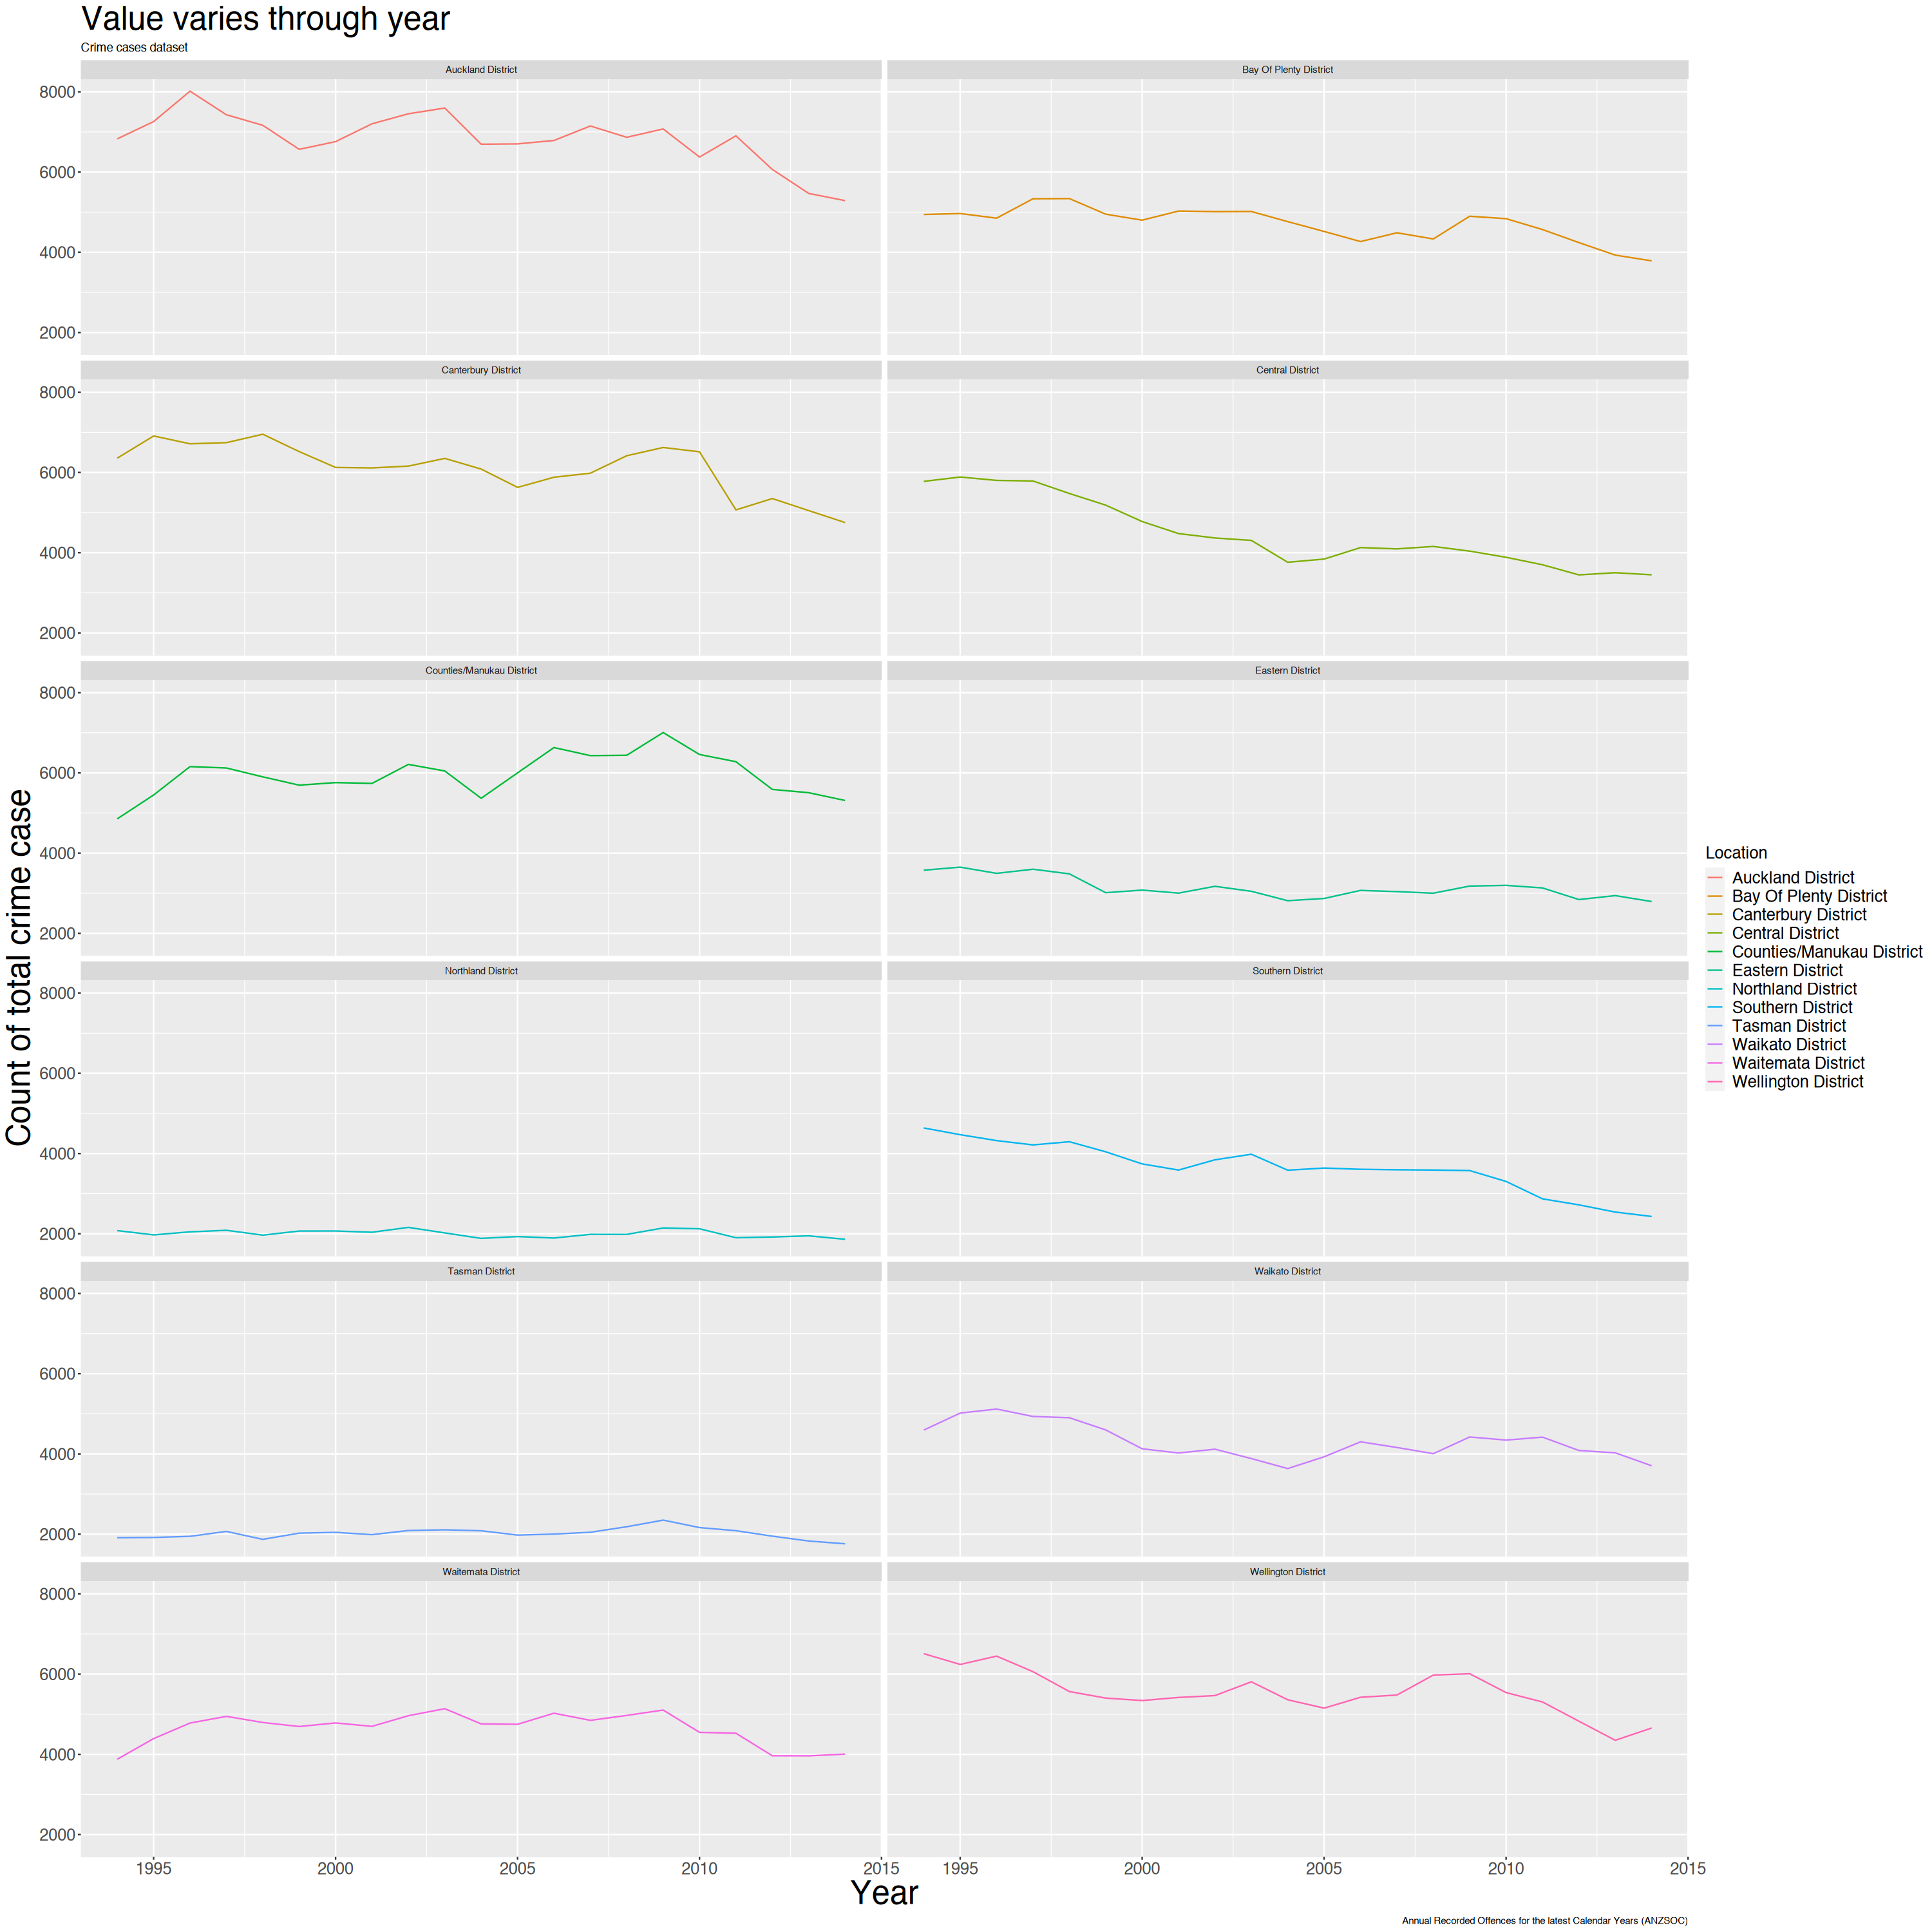

In [45]:
# Review plot
crime_df_plot

In [46]:
# Save a ggplot with a sensible default
ggsave("crime_df_plot.pdf", width = 15, height = 10, plot = crime_df_plot, device = 'pdf')

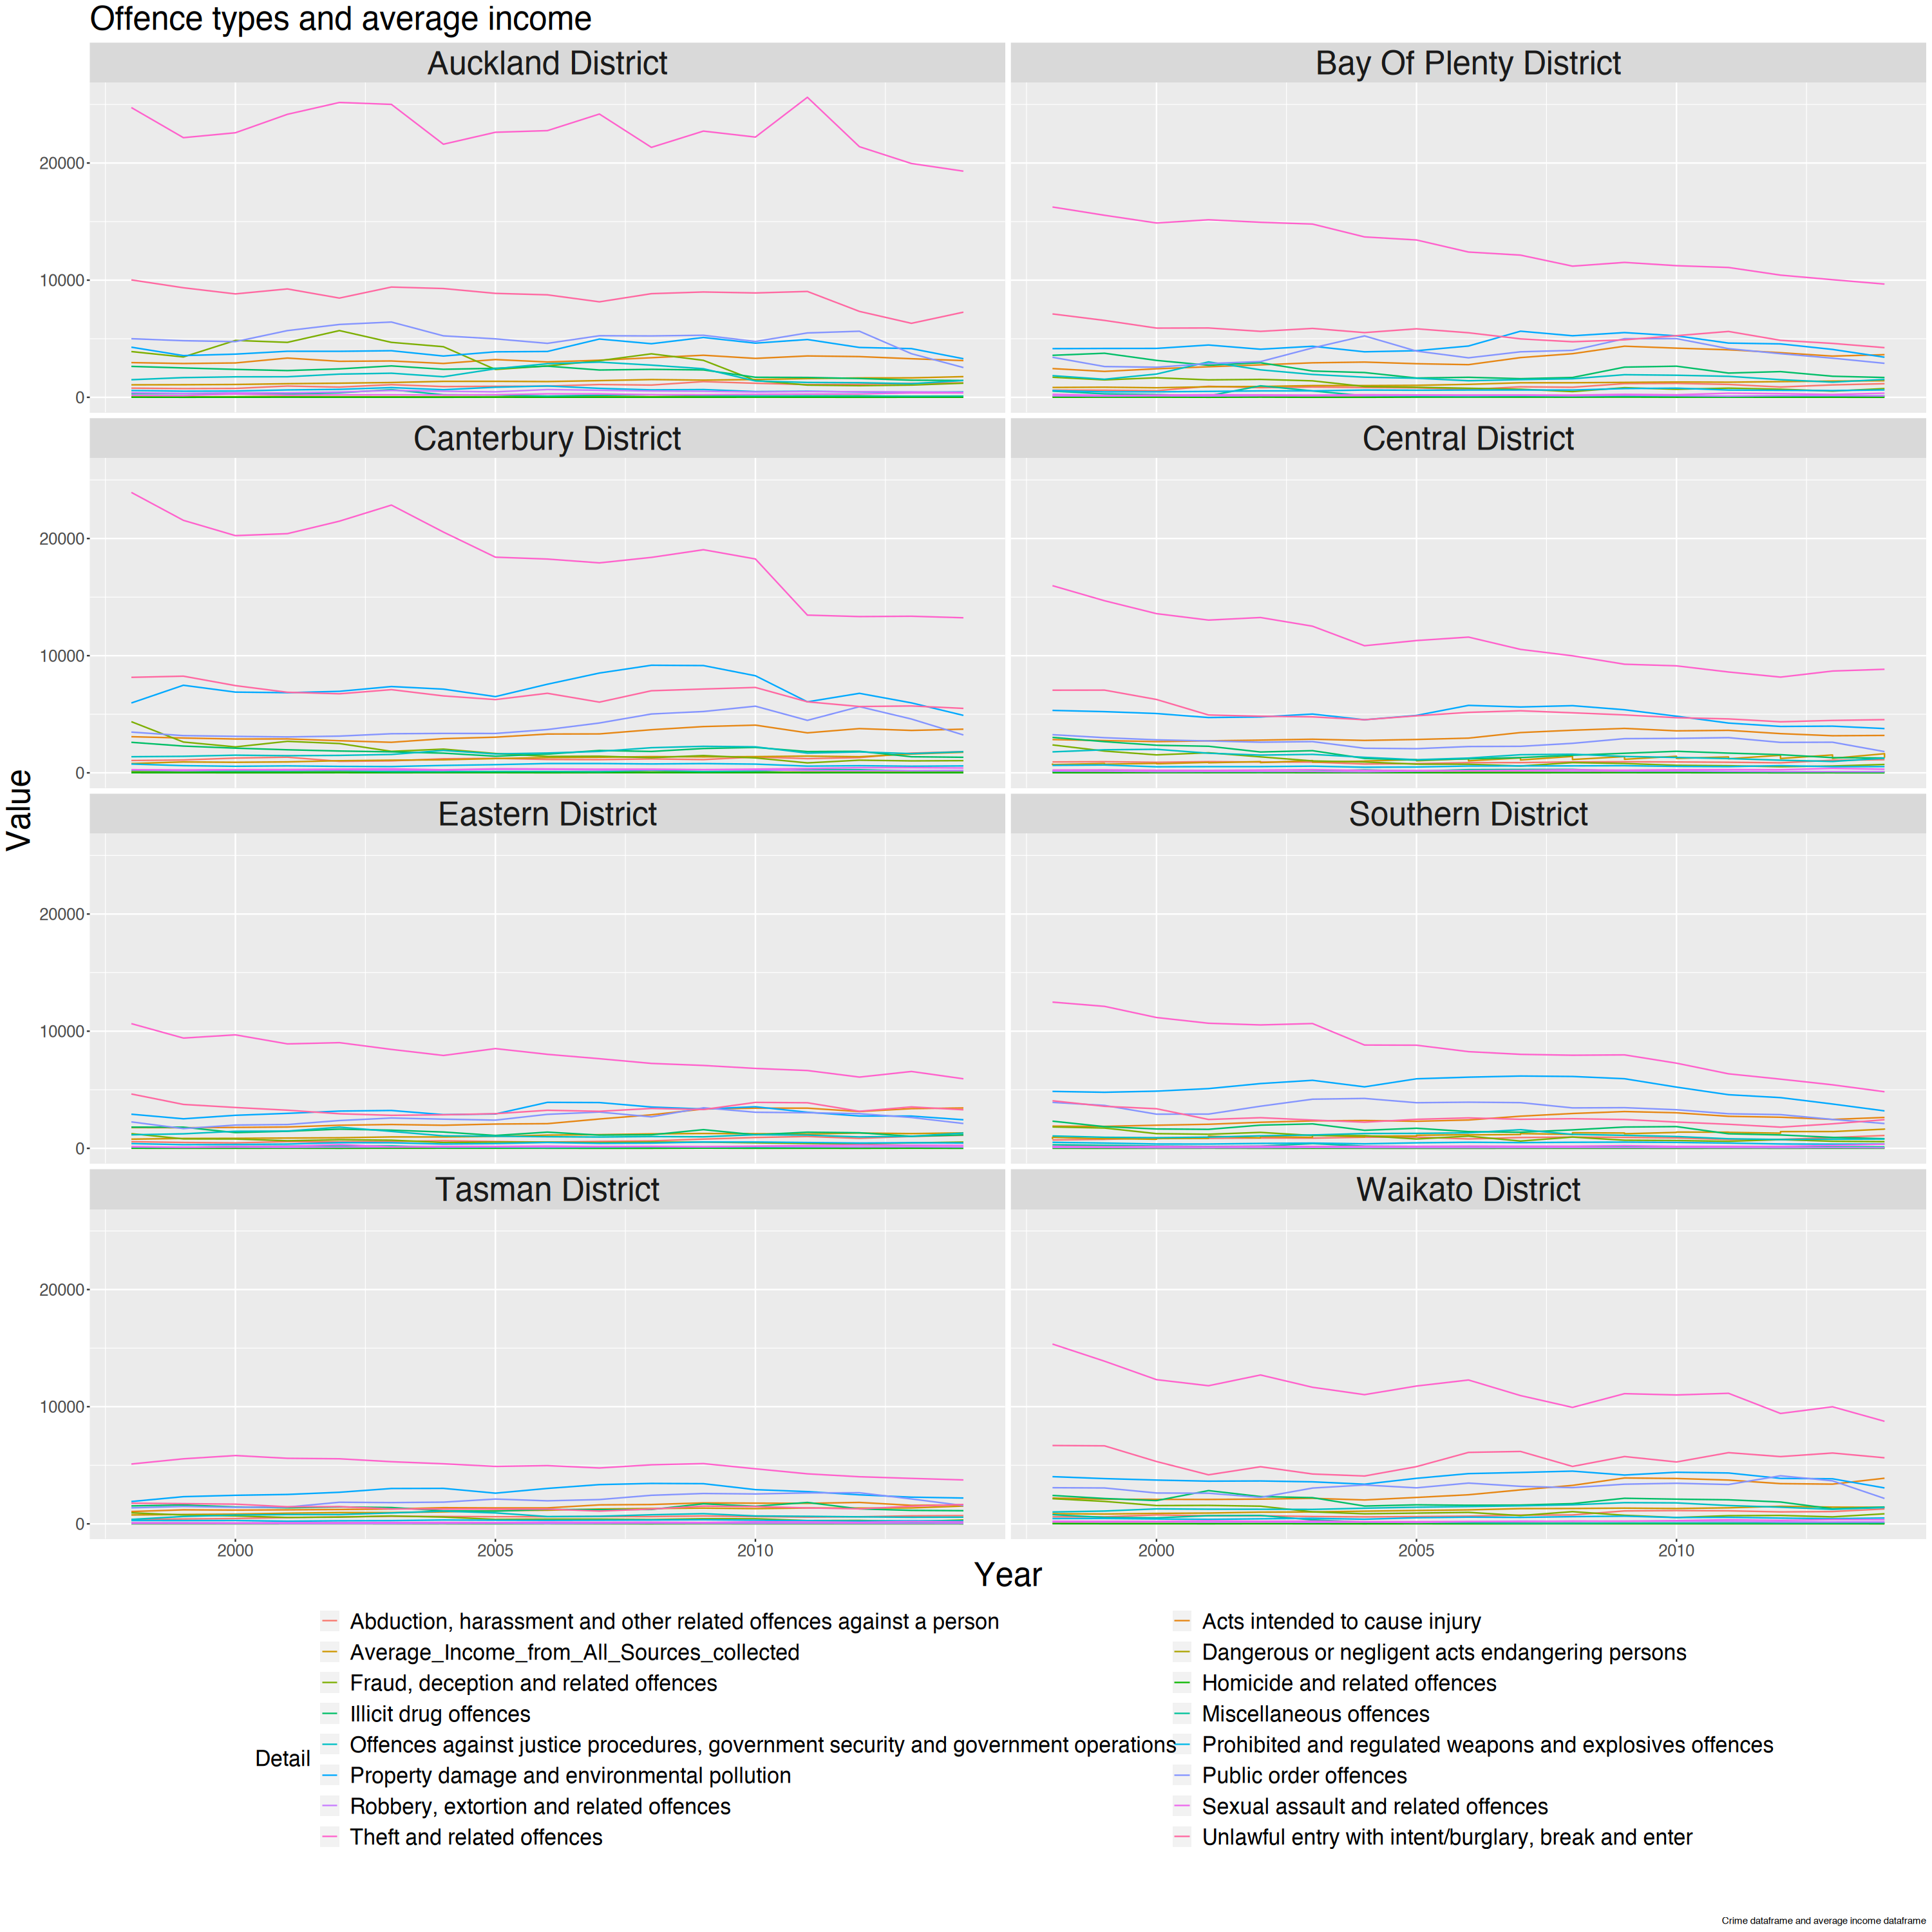

In [47]:
# Review plot
crime_income_plot

In [54]:
# Save a ggplot with a sensible default
ggsave("crime_income_plot.pdf", width = 25, height = 25, plot = crime_income_plot, device = 'pdf')

# Saving dataframe in CSV form

In [49]:
# Check Working directory
getwd()

[1] "/Users/junweil/Desktop"

In [50]:
# Set path
#setwd('~/Desktop')

In [51]:
# Merged dataframe (Crime dataframe and Average income dataframe)
inner_joined_df %>%
  write.csv("Inner_joined_df.csv")

In [52]:
# Long form average income dataframe
income_df %>%
  write.csv("average_income_df_long.csv")

In [53]:
crime_df <- crime_df[crime_df$Measure == "Recorded", ]
crime_df %>%
  write.csv("crime_df.csv")

# Conclusion